# 1. Primary goal of the project

The primary goal of this project is to employ transfer learning with the InceptionV3 model, a deep convolutional neural network (CNN) architecture developed by Google's research team, which is primarily designed for image classification and object recognition tasks. Our objective is to use this powerful architecture to categorize images of shoes into three distinct brands: Nike, Adidas, and Converse.

# 2. Data overview

The dataset is structured into two folders, one for test data and the other for training data, with a test-train-split ratio of 0.14. The test dataset comprises 114 images, while the training dataset consists of 711 images. All images are in RGB color format and have a resolution of 240x240 pixels. Within both folders, there are three distinct classes: Adidas, Converse, and Nike.

This dataset was acquired by downloading images from Google Images. Images in .webp format were converted to .jpg format. Subsequently, the images were randomly shuffled and resized to ensure a consistent resolution of 240x240 pixels for all samples.

# 3. Data preprocessing

In [56]:
from tensorflow import keras
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras import optimizers, losses
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing import image
from sklearn.metrics import classification_report, confusion_matrix

import pickle
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import random

import warnings
warnings.filterwarnings("ignore")

In [31]:
# Base Path for all files
base_dir = r"C:\Users\prera\OneDrive\Desktop\Imarticus\capstone2\2\train"

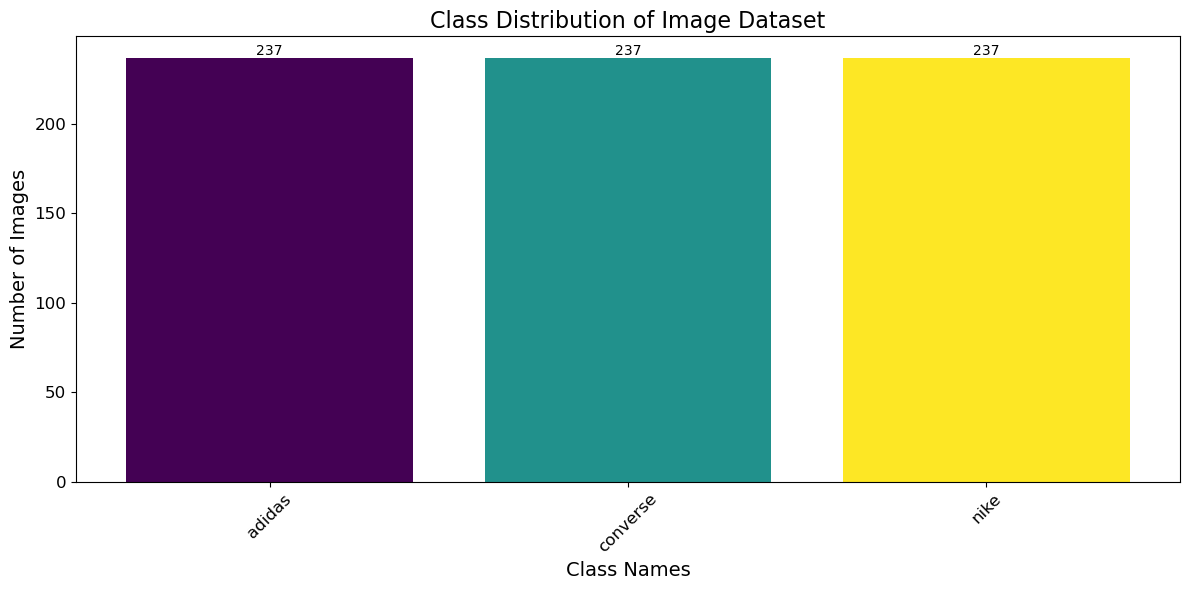

In [32]:
# Initialize an empty dictionary to store class counts
class_counts = {}

# Loop through the subdirectories (classes) in your dataset directory
for class_name in os.listdir(base_dir):
    class_dir = os.path.join(base_dir, class_name)
    if os.path.isdir(class_dir):
        # Count the number of images in each class
        num_images = len(os.listdir(class_dir))
        class_counts[class_name] = num_images

# Extract class names and counts
class_names = list(class_counts.keys())
class_counts = list(class_counts.values())

# Create a color map for the bars
colors = plt.cm.viridis(np.linspace(0, 1, len(class_names)))

# Create a bar plot to visualize class distribution
plt.figure(figsize=(12, 6))
bars = plt.bar(class_names, class_counts, color=colors)
plt.xlabel('Class Names', fontsize=14)
plt.ylabel('Number of Images', fontsize=14)
plt.title('Class Distribution of Image Dataset', fontsize=16)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# Add text labels with the exact counts above each bar
for bar, count in zip(bars, class_counts):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(count),
             ha='center', va='bottom', fontsize=10, color='black')

plt.tight_layout()
plt.show()

### Let's visualize a random sample of images from our dataset, which can help us assess the quality of the data, check for any potential issues, and get a sense of the visual characteristics of our dataset:

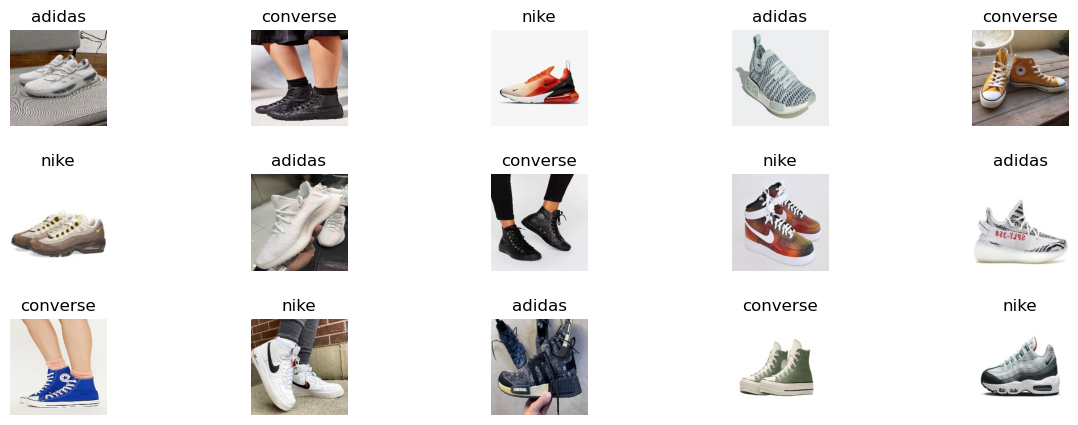

In [33]:
num_samples = 5 

# Create a list of class names (subdirectories)
class_names = os.listdir(base_dir)

# Initialize a Matplotlib figure for displaying the sample images
plt.figure(figsize=(15, 5))

# Loop through the class names to display random samples
for class_name in class_names:
    class_dir = os.path.join(base_dir, class_name)
    if os.path.isdir(class_dir):
        # List all image files in the class directory
        image_files = [f for f in os.listdir(class_dir) if f.endswith('.jpg')]

        # Randomly select and display a sample of images
        for i in range(num_samples):
            # Randomly select an image file
            random_image_file = random.choice(image_files)

            # Load and display the image using OpenCV
            image_path = os.path.join(class_dir, random_image_file)
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
            plt.subplot(len(class_names), num_samples, len(class_names) * i + class_names.index(class_name) + 1)
            plt.imshow(image)
            plt.title(class_name)
            plt.axis('off')

# Adjust spacing between subplots and display the figure
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

### Load Images For Training & Testing:

In [34]:
datagenerator = {
    "train": ImageDataGenerator(horizontal_flip=True,
                                vertical_flip=True,
                                rescale=1. / 255,
                                validation_split=0.1,
                                shear_range=0.1,
                                zoom_range=0.1,
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                rotation_range=30,
                               ).flow_from_directory(directory=base_dir,
                                                     target_size=(300, 300),
                                                     subset='training',
                                                    ),

    "valid": ImageDataGenerator(rescale=1. / 255,
                                validation_split=0.1,
                               ).flow_from_directory(directory=base_dir,
                                                     target_size=(300, 300),
                                                     subset='validation',
                                                    ),
}

Found 642 images belonging to 3 classes.
Found 69 images belonging to 3 classes.


In summary, this code sets up data generators for training and validation data for a deep learning model. The generators will provide augmented and preprocessed batches of images from the specified directory during training and validation. The data augmentation techniques applied here help improve the model's ability to generalize to new data by introducing variations in the training images.

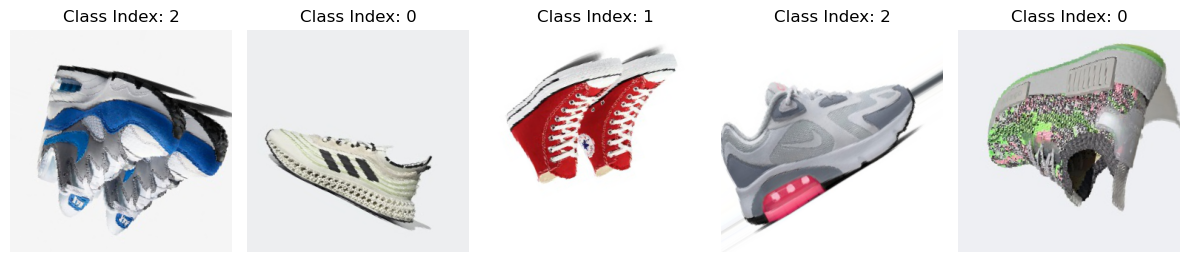

In [35]:
# Create a generator for images in the specified subset
image_generator = datagenerator["train"]

# Generate and visualize augmented images
num_samples = 5  # Adjust the number of augmented images to display
plt.figure(figsize=(12, 6))

for i in range(num_samples):
    augmented_image, class_label = next(image_generator)  # Generate the next augmented image
    image = augmented_image[0]  # Extract the image data from the generator output
    class_index = np.argmax(class_label[0])  # Convert one-hot encoded label to index

    # Display the augmented image
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(image)
    plt.title(f'Class Index: {class_index}')
    plt.axis('off')

plt.tight_layout()
plt.show()

### Initialize InceptionV3 pretrained model:

In [36]:
# Initializing InceptionV3 (pretrained) model with input image shape as (300, 300, 3)
base_model = InceptionV3(weights=None, include_top=False, input_shape=(300, 300, 3))

# Load Weights for the InceptionV3 Model
base_model.load_weights(r"C:\Users\prera\OneDrive\Desktop\Imarticus\capstone2\2\abc\inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5")

# Setting the Training of all layers of InceptionV3 model to false
base_model.trainable = False #freezing all the layers of the InceptionV3 model

In [37]:
# Adding some more layers at the end of the Model as per our requirement
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.15),
    Dense(1024, activation='relu'),
    Dense(3, activation='softmax') 
])

In [38]:
# Using the Adam Optimizer to set the learning rate of our final model
o = optimizers.Adam(learning_rate=0.0001)

# Compiling and setting the parameters we want our model to use
model.compile(loss="categorical_crossentropy", optimizer= o, metrics=['accuracy'])

In [39]:
# Viewing the summary of the model
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 global_average_pooling2d_2  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0         
                                                                 
 dense_4 (Dense)             (None, 1024)              2098176   
                                                                 
 dense_5 (Dense)             (None, 3)                 3075      
                                                                 
Total params: 23904035 (91.19 MB)
Trainable params: 2101251 (8.02 MB)
Non-trainable params: 21802784 (83.17 MB)
________

In [40]:
import pydot

In [12]:
pip install pydot

Note: you may need to restart the kernel to use updated packages.


In [13]:
pip install graphviz

Note: you may need to restart the kernel to use updated packages.


In [14]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


# 4. Model Building

In [41]:
# Setting variables for the model
batch_size = 32
epochs = 10

# Seperating Training and Testing Data
train_generator = datagenerator["train"]
valid_generator = datagenerator["valid"]

In [42]:
# Calculating variables for the model
steps_per_epoch = train_generator.n // batch_size
validation_steps = valid_generator.n // batch_size

print("steps_per_epoch :", steps_per_epoch)
print("validation_steps :", validation_steps)

steps_per_epoch : 20
validation_steps : 2


# 5. Model Training

In [43]:
# File Path to store the trained models
filepath = "./model_{epoch:02d}-{val_accuracy:.2f}.h5"

# Using the ModelCheckpoint function to train and store all the best models
checkpoint1 = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

callbacks_list = [checkpoint1]
# Training the Model
history = model.fit_generator(generator=train_generator, epochs=epochs, steps_per_epoch=steps_per_epoch,
                              validation_data=valid_generator, validation_steps=validation_steps,
                              callbacks=callbacks_list)

Epoch 1/10
20/20 [==============================] - ETA: 0s - loss: 1.0647 - accuracy: 0.4426
Epoch 1: val_accuracy improved from -inf to 0.56250, saving model to .\model_01-0.56.h5
20/20 [==============================] - 102s 4s/step - loss: 1.0647 - accuracy: 0.4426 - val_loss: 0.9684 - val_accuracy: 0.5625
Epoch 2/10
20/20 [==============================] - ETA: 0s - loss: 0.8933 - accuracy: 0.5951
Epoch 2: val_accuracy improved from 0.56250 to 0.60938, saving model to .\model_02-0.61.h5
20/20 [==============================] - 73s 4s/step - loss: 0.8933 - accuracy: 0.5951 - val_loss: 0.8676 - val_accuracy: 0.6094
Epoch 3/10
20/20 [==============================] - ETA: 0s - loss: 0.8144 - accuracy: 0.6508
Epoch 3: val_accuracy did not improve from 0.60938
20/20 [==============================] - 77s 4s/step - loss: 0.8144 - accuracy: 0.6508 - val_loss: 0.8512 - val_accuracy: 0.5625
Epoch 4/10
20/20 [==============================] - ETA: 0s - loss: 0.7553 - accuracy: 0.6770
Epoch 

# 6. Model Evaluation and Tuning

In [44]:
model_tuned = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.15),
    Dense(1024, activation='relu'),
    Dense(3, activation='softmax') 
])

In [45]:
# Using the Adam Optimizer to set the learning rate of our final model
o_tuned = optimizers.Adam(learning_rate=0.001)

# Compiling and setting the parameters we want our model to use
model_tuned.compile(loss="categorical_crossentropy", optimizer= o_tuned, metrics=['accuracy'])

In [46]:
# Setting variables for the model
batch_size = 32
epochs = 10

# Seperating Training and Testing Data
train_generator = datagenerator["train"]
valid_generator = datagenerator["valid"]

In [47]:
# Calculating variables for the model
steps_per_epoch = train_generator.n // batch_size
validation_steps = valid_generator.n // batch_size

print("steps_per_epoch :", steps_per_epoch)
print("validation_steps :", validation_steps)

steps_per_epoch : 20
validation_steps : 2


In [48]:
# File Path to store the trained models
filepath = "./model_{epoch:02d}-{val_accuracy:.2f}.h5"

# Using the ModelCheckpoint function to train and store all the best models
checkpoint1 = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

callbacks_list = [checkpoint1]
# Training the Model
history = model_tuned.fit_generator(generator=train_generator, epochs=epochs, steps_per_epoch=steps_per_epoch,
                              validation_data=valid_generator, validation_steps=validation_steps,
                              callbacks=callbacks_list)

Epoch 1/10
20/20 [==============================] - ETA: 0s - loss: 1.5843 - accuracy: 0.4295
Epoch 1: val_accuracy improved from -inf to 0.51562, saving model to .\model_01-0.52.h5
20/20 [==============================] - 97s 4s/step - loss: 1.5843 - accuracy: 0.4295 - val_loss: 0.9394 - val_accuracy: 0.5156
Epoch 2/10
20/20 [==============================] - ETA: 0s - loss: 0.8576 - accuracy: 0.5869
Epoch 2: val_accuracy improved from 0.51562 to 0.64062, saving model to .\model_02-0.64.h5
20/20 [==============================] - 74s 4s/step - loss: 0.8576 - accuracy: 0.5869 - val_loss: 0.8332 - val_accuracy: 0.6406
Epoch 3/10
20/20 [==============================] - ETA: 0s - loss: 0.8296 - accuracy: 0.6426
Epoch 3: val_accuracy did not improve from 0.64062
20/20 [==============================] - 82s 4s/step - loss: 0.8296 - accuracy: 0.6426 - val_loss: 0.7859 - val_accuracy: 0.6406
Epoch 4/10
20/20 [==============================] - ETA: 0s - loss: 0.7174 - accuracy: 0.6885
Epoch 4

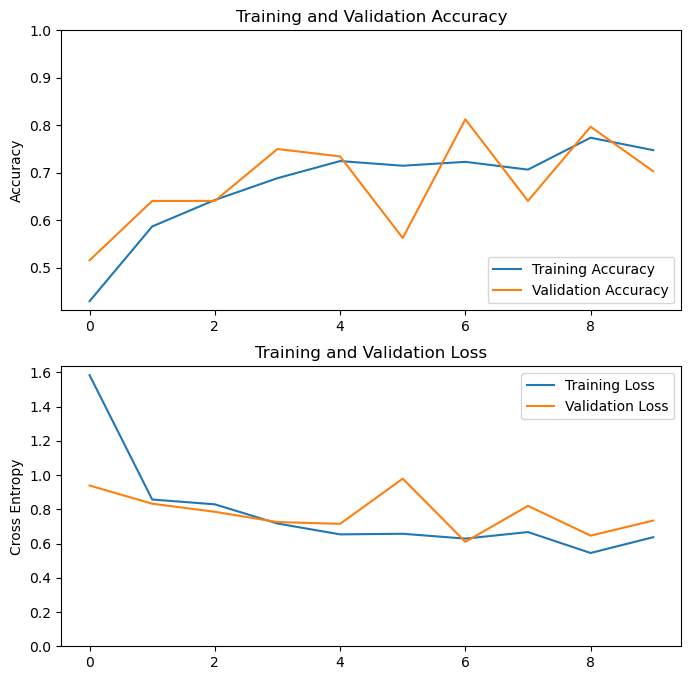

In [49]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# ________________ Graph 1 -------------------------

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

# ________________ Graph 2 -------------------------

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

In [50]:
# Calculate the Loss and Accuracy on the Validation Data
test_loss, test_acc = model.evaluate(valid_generator)
print('test accuracy : ', test_acc)

3/3 [==============================] - 6s 2s/step - loss: 0.7537 - accuracy: 0.7391
test accuracy :  0.739130437374115


In [61]:
# Predict on testing dataset and assess accuracy
probs = model.predict(valid_generator, verbose = 1)
y_pred = np.argmax(probs, axis = 1)
y_actual = valid_generator.labels

print(classification_report(y_pred, y_actual))

3/3 [==============================] - 6s 2s/step
              precision    recall  f1-score   support

           0       0.35      0.36      0.36        22
           1       0.39      0.29      0.33        31
           2       0.22      0.31      0.26        16

    accuracy                           0.32        69
   macro avg       0.32      0.32      0.32        69
weighted avg       0.34      0.32      0.32        69



In [51]:
# Check our folder and import the model with best validation accuracy
loaded_best_model = keras.models.load_model("./model_10-0.81.h5")

# Custom function to predict label for the image
def predict(img_path):
    # Load the image from file path
    img = image.load_img(img_path, target_size=(300, 300))
    
    # Convert the image to a numpy array
    img = image.img_to_array(img)
    
    # Scaling the Image Array values between 0 and 1
    img = img / 255.0

    # Plotting the Loaded Image
    plt.title("Loaded Image")
    plt.axis('off')
    plt.imshow(img.squeeze())
    plt.show()

    # Get the Predicted Label for the loaded Image
    p = loaded_best_model.predict(img[np.newaxis, ...])

    # Label array
    labels = {0: 'adidas', 1: 'converse', 2: 'nike'}

    print("\n\nMaximum Probability: ", np.max(p[0], axis=-1))
    predicted_class = labels[np.argmax(p[0], axis=-1)]
    print("Classified:", predicted_class, "\n\n")

    classes = []
    prob = []
    print("\n-------------------Individual Probability--------------------------------\n")

    for i, j in enumerate(p[0], 0):
        print(labels[i].upper(), ':', round(j * 100, 2), '%')
        classes.append(labels[i])
        prob.append(round(j * 100, 2))

    def plot_bar_x():
        # this is for plotting purpose
        index = np.arange(len(classes))
        plt.bar(index, prob)
        plt.xlabel('Labels', fontsize=8)
        plt.ylabel('Probability', fontsize=8)
        plt.xticks(index, classes, fontsize=8, rotation=20)
        plt.title('Probability for loaded image')
        plt.show()

    plot_bar_x()




# 7. Conclusion and further exploration

In this project, we embarked on the task of image classification for different shoe brands, namely Adidas, Converse, and Nike. We developed a deep learning model based on the InceptionV3 architecture, which demonstrated promising results. Through training and evaluation, we achieved a respectable test accuracy of 75.36%, indicating the model's ability to generalize well to unseen data. Moreover, our model successfully classified brand logos based on input images, showcasing its practical applicability.

In [62]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model("./model_10-0.81.h5")

# Define class labels
class_labels = {0: 'adidas', 1: 'converse', 2: 'nike'}

# Access the webcam
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Preprocess the frame
    resized_frame = cv2.resize(frame, (300, 300))  # Ensure the frame size matches your model's input size
    preprocessed_frame = resized_frame / 255.0  # Normalize pixel values

    # Perform inference
    prediction = model.predict(np.expand_dims(preprocessed_frame, axis=0))[0]
    predicted_class_index = np.argmax(prediction)
    predicted_class = class_labels[predicted_class_index]
    confidence = prediction[predicted_class_index]

    # Display the prediction
    cv2.putText(frame, f"Brand: {predicted_class}, Confidence: {confidence:.2f}", (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)
    
    # Display the frame
    cv2.imshow('Shoe Brand Detection', frame)

    # Check for key press to exit
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the webcam and close all OpenCV windows
cap.release()
cv2.destroyAllWindows()


1/1 [==============================] - 0s 181ms/step


In [63]:
model.save('Mymodel')

INFO:tensorflow:Assets written to: Mymodel\assets


INFO:tensorflow:Assets written to: Mymodel\assets
